In [1]:
import copy
import numpy as np
import sys

In [2]:
import analysis_config

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [5]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [6]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

# Load Data

In [7]:
default_sim = 'm12i'
default_snum = 172

In [8]:
sim_name, snum = exec_helpers.choose_config_or_commandline(
    [ default_sim, default_snum ]
)
print( 'Using sim {}, snum {}'.format( sim_name, snum ) )

Using sim m12i, snum 172


In [9]:
galdef = ''

In [10]:
file_manager = file_management.FileManager( 'CGM_fate' )

In [11]:
defaults = file_manager.get_linefinder_analysis_defaults(
    '_CGM_snum{}'.format( snum ),
    sim_name = sim_name,
    galdef = galdef
)

In [12]:
ind = defaults['ahf_index'] - snum

In [13]:
w = a_worldlines.Worldlines( **defaults )

In [14]:
w.retrieve_halo_data()

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [15]:
print( w.tag )

m12i_CGM_snum172


In [16]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{11} M_\odot$, z=2.0


In [17]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [18]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

In [19]:
g_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_GAS,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
)

In [20]:
g_plotter = generic_plotter.GenericPlotter(
    g_data,
    label=plot_label,
)

In [21]:
s_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],    
)

In [22]:
s_plotter = generic_plotter.GenericPlotter( s_data )

### Create a circle to plot

In [23]:
r_gal = w.r_gal[ind]

In [24]:
circle = []
for phi in np.linspace( 0., 2.*np.pi, 256 ):
    
    circle.append(
        [ r_gal*np.cos(phi), r_gal*np.sin(phi), 0. ]
    )
    
circle = np.array( circle )

rotated_circle = data_operations.align_axes( circle, s_data.total_ang_momentum, )

# Illustrative Plot

In [25]:
r_vir = w.r_vir.values[ind]

In [26]:
t_show_min = {
    465 : 0.5,
    172 : 0.25,
    214 : 0.25,
}
t_show_max = {
    465 : 1.0,
    172 : 0.5,
    214 : 0.5,
}

In [27]:
data_args = {
    465 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    172 : { 'smooth_data' : True, 'smoothing_window_length' : 11 },
    214 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
}

is_CGM_accreted


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


is_CGM_accreted_to_satellite
is_CGM_ejected


is_CGM_accreted
is_CGM_accreted_to_satellite
is_CGM_ejected
File saved at /home1/03057/zhafen/papers/CGM_fate/figures/streamlines_m12i_CGM_snum172.png


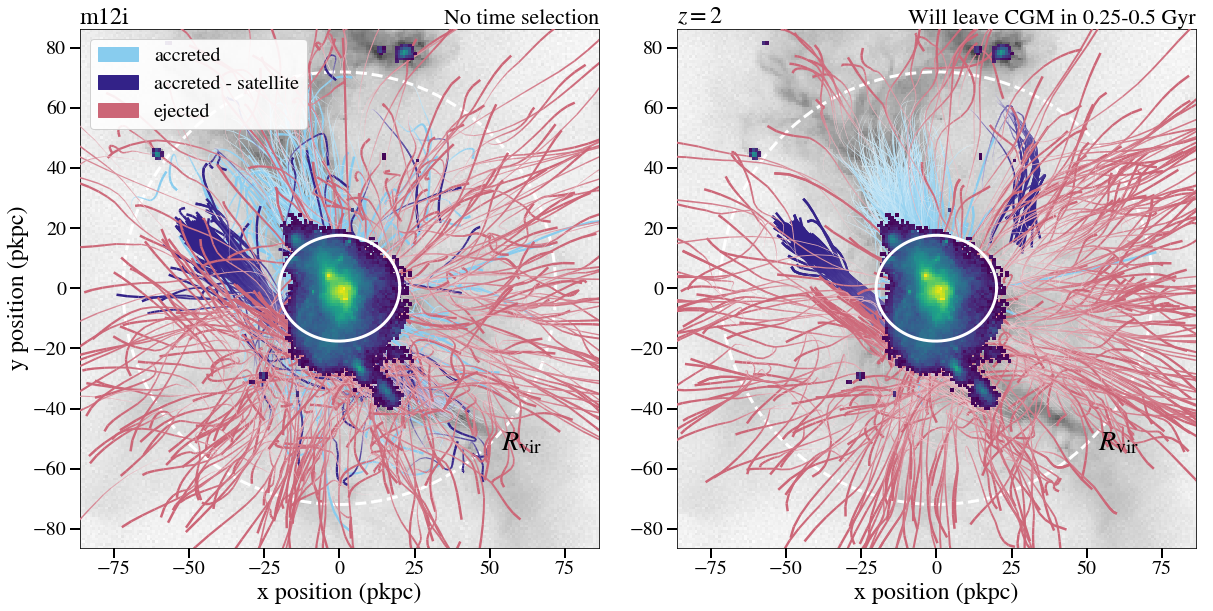

In [28]:
fig = plt.figure( figsize=(20,10), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 1, 2 )
axs = [ plt.subplot( gs[0,0] ), plt.subplot( gs[0,1] ) ]

gs.update( wspace=0.15 )

plotted_range = [ -1.2*r_vir, 1.2*r_vir ]

x_axis = 'Rx'
y_axis = 'Ry'

for j, sample_selected_interval in enumerate( [ False, True ] ):
    
    ax = axs[j]
    
    labels = []
    color_objects = []
    for i, classification in enumerate( classification_list ):

        w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
        
        # Don't plot CGM accreted-satellite for m10s, because there are just
        # too few particles
        if (
            classification == 'is_CGM_accreted_to_satellite' and
            config.MASS_BINS[sim_name] == 'm10'
        ):
            continue
        # Don't plot CGM accreted-satellite for m11s at high-z when applying the time cut, because there are just
        # too few particles
        if (
            classification == 'is_CGM_accreted_to_satellite' and
            config.MASS_BINS[sim_name] == 'm11' and
            ax.is_last_col() and
            snum == 172
        ):
            continue
            
        # Don't plot CGM still for m12s at high-z, because there are just
        # too few particles
        if (
            classification == 'is_CGM_still' and
            config.MASS_BINS[sim_name] == 'm12' and
            snum == 172
        ):
            continue
            
        # Don't plot halo transfer, as it's an unimportant component
        if classification == 'is_CGM_halo_transfer':
            continue
            
        # Don't plot CGM still when we're doing fates close to their exit time
        if classification == 'is_CGM_still' and sample_selected_interval:
            continue
        
        print( classification )
        w_plotter.plot_streamlines(
            x_axis,
            y_axis,
            ax = ax,
            classification = classification,
            classification_ind = ind,
            start_ind = 'time_based',
            end_ind = ind,
            t_start = t_show_max[snum],
            sample_size = 500,
            sample_selected_interval = sample_selected_interval,
            selected_interval_type = 'time_until_not',
            selected_interval_classification = 'is_in_CGM_or_interface',
            t_show_min = t_show_min[snum],
            t_show_max = t_show_max[snum],
            x_data_kwargs = data_args[snum],
            y_data_kwargs = data_args[snum],
            linewidth = 2.5,
            plot_halos = False,
#             plot_xlabel = ( sim_name == 'm10y' ),
            plot_ylabel = ax.is_first_col(),
            x_label = '{} position (pkpc)'.format( x_axis[1] ),
            y_label = '{} position (pkpc)'.format( y_axis[1] ),
            x_range = plotted_range,
            y_range = plotted_range,
            fontsize = 24,
        )

        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
            ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )                                                                    
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

    if j==0:
        plot_label = sim_name
    else:
        plot_label = r'$z = {:.2g}$'.format( g_data.redshift )
    vmaxes = {
        'm10' : 4e3,
        'm11' : 4e3,
        'm12' : 4e3,
    }
    vmax = vmaxes[config.MASS_BINS[sim_name]]
    g_plotter.histogram2d(
        x_axis,
        y_axis,
        cmap = cm.Greys,
        ax = ax,
        x_range = plotted_range,
        y_range = plotted_range,
        n_bins = 200,
#         vmin = 1,
        vmax = vmax,
        add_colorbar = False,
        add_x_label = False,
        add_y_label = False,
        label_fontsize = 24,
        plot_label = plot_label,
    )
    
    vmins = {
        172 : {
            'm10' : 10,
            'm11' : 10,
            'm12' : 20,
        },
        214 : {
            'm12' : 50,
        },
        465 : {
            'm10' : 20,
            'm11' : 20,
            'm12' : 5e2,
        },
    }
    vmin = vmins[snum][config.MASS_BINS[sim_name]]
    s_plotter.histogram2d(
        x_axis,
        y_axis,
        cmap = cm.viridis,
        ax = ax,
        x_range = plotted_range,
        y_range = plotted_range,
        n_bins = 200,
        vmin = vmin,
#         vmax = 4e3,
        plot_label = None,
        add_colorbar = False,
        add_x_label = False,
        add_y_label = False,
        label_fontsize = 20,
        zorder = 150,
        min_bin_value_displayed = vmin,
    )

#     s_plotter.scatter(
#         'Rx',
#         'Ry',
#         color = '#303030',
# #         color = '#e6e032',
#         marker = '*',
#         ax = ax,
#         x_range = plotted_range,
#         y_range = plotted_range,
#         n_subsample = 2000,
#         zorder = 150.,
#         plot_label = None,
#         add_x_label = False,
#         add_y_label = False,
#     )

    # Virial Radius circle
    cir = mpatches.Circle(
        [0, 0],
        radius = r_vir,
        linewidth = 3,
        color = 'w',
        linestyle = '--',
        fill = False,
        facecolor = 'w',
    )
    ax.add_patch( cir )
    ax.annotate(
        s = r'$R_{\rm vir}$',
        xy = ( .7475*r_vir, -.7475*r_vir ),
        xycoords = 'data',
        fontsize = 28,
        color = 'k',
        zorder = 150,
    )
    
    # Galaxy disk circle
    ax.plot(
        rotated_circle[:,0],
        rotated_circle[:,1],
        color = 'w',
        linewidth = 3,
        zorder = 200,
    )
    
    if ax.is_first_col():
        filter_label = 'No time selection'
    if ax.is_last_col():
        filter_label = 'Will leave CGM in {}-{} Gyr'.format(
            t_show_min[snum],
            t_show_max[snum],
        )
    ax.annotate(
        s = filter_label,
        xy = ( 1., 1. ),
        xycoords = 'axes fraction',
        va = 'bottom',
        ha = 'right',
        fontsize = 22,
    )

    if ax.is_first_col():
        leg = ax.legend(
            color_objects,
            labels,
            prop={'size': 20},
            ncol=1,
    #         loc=(0.65, 0.83),
            loc='upper left',
            fontsize=24,
            framealpha = 0.9,
        )
        leg.set_zorder( 200 )

    ax.set_aspect( 'equal' )

save_file = 'streamlines_{}.png'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
    resolution = 50,
)

fig

# Plot vs Time

In [29]:
w.data_masker.clear_masks()

In [30]:
# Set limits
y_max = np.nanpercentile( w.get_selected_data_over_time(
    data_key = 'R',
    snum = snum,
    classification = 'is_CGM_IGM_accretion',
)[:,0], 80. )*1.1
y_max = w.r_vir.values[0]*1.5

# Plot for Next Fate

In [31]:
used_classification_list = copy.copy( classification_list )
used_classification_list.remove( 'is_CGM_halo_transfer' )

In [32]:
# Don't plot CGM accreted-satellite for m10s at low-z when applying the time cut, because there are just
# too few particles
if (config.MASS_BINS[sim_name] == 'm10'):
    used_classification_list.remove( 'is_CGM_accreted_to_satellite' )
# Don't plot CGM still for m12s at high-z, because there are just
# too few particles
if (
    snum < 465 and
    config.MASS_BINS[sim_name] == 'm12'
):
    used_classification_list.remove( 'is_CGM_still' )

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/r_vs_time_m12i_CGM_snum172.pdf


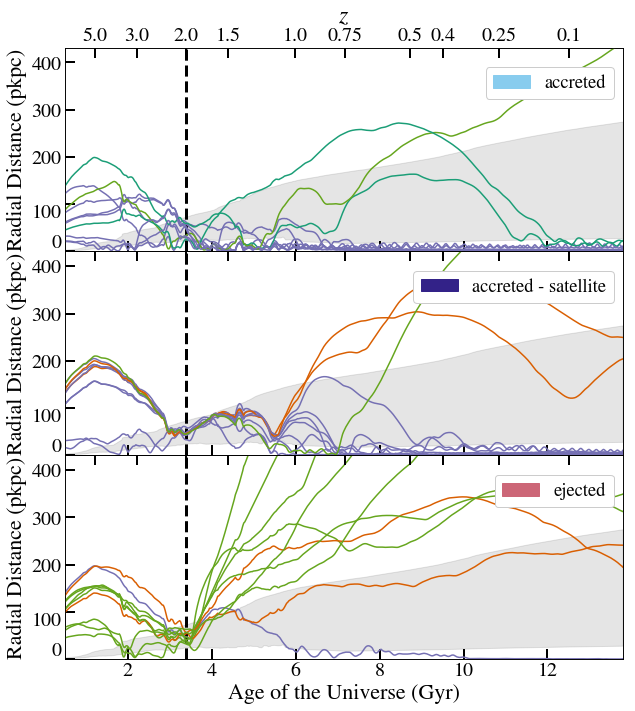

In [83]:
fig = plt.figure( figsize=(10,15), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 4, 1 )

y_maxes = []
for i, classification in enumerate( used_classification_list ):
    
    # Minor category, skip
    if classification == 'is_CGM_halo_transfer':
        continue
    
    ax = plt.subplot(gs[i,0])
    
#     if ax.is_first_row():
#         ax.annotate(
#             s = m_plot_label,
#             xy = (0,1.1),
#             xycoords = 'axes fraction',
#             va = 'bottom',
#             fontsize = 24,
#         )
    if classification == 'is_CGM_IP':
        ax.annotate(
            s = m_plot_label,
            xy = (0.05,0.95),
            xycoords = 'axes fraction',
            va = 'top',
            fontsize = 24,
        )
    
    gs.update(wspace=0.025, hspace=0.0001)
    
    w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
    
    class_y_max = w_plotter.plot_streamlines_vs_time(
        y_key = 'R',
        classification = classification,
        classification_ind = ind,
        start_ind = 0,
        end_ind = 595,
        sample_size = 10,
        y_data_kwargs = { 'smooth_data' : True },
        ax = ax,
        x_range = [0.5, 13.8 ],
        y_range = [0., 550, ],
        horizontal_line_value = None,
        plot_CGM_region = True,
        CGM_region_alpha = 0.1,
        return_y_max = True,
        classifications_to_color_on = p_constants.CLASSIFICATIONS_LOCATION,
        ctco_ind = 0,
#         line_features = {
#             'is_class': {
#                 'key': classification,
#                 'value': True,
#                 'data_kwargs': {},
#                 'line_attrs': {
#                     'linewidth': 3,
#                     'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                     },
#             },
#             'is_gas': {
#                 'key': classification,
#                 'value': False,
#                 'data_kwargs': {},
#                 'line_attrs': {
#                     'linewidth': 1,
#                     'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                     'linestyle': '--',
#                     },
#                 }
#         },
    )
    y_maxes.append( class_y_max )
        
    # Make virtual artists to allow a legend to appear
    labels = []
    color_objects = []
    color_object = matplotlib.patches.Rectangle(                         
        (0, 0),                                                          
        1,                                                               
        1,                                                               
        fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        alpha = p_constants.CLASSIFICATION_ALPHA,                        
    )                                                                    
    color_objects.append( color_object )                                 
    labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
    
    # Plot the outer edge of the galaxy under galdefv2
#     ax.plot( w.get_data( 'time')[:r_gal.size], w.r_gal, color='k', linewidth=3.5 )

    # Legend
    l = ax.legend(
        color_objects,
        labels,
        prop={'size': 18.5},
        ncol=1,
        bbox_to_anchor=(1, 0.95),
        loc='upper right',
        fontsize=20,
        framealpha=1.,
    )
    l.set_zorder( 200. )
        
# Changes to axes
for i, classification in enumerate( used_classification_list ):
    
    ax = plt.subplot(gs[i,0])
    ax.set_ylim( 0, 1.05*y_max )
    
    # Add redshift to the axis
    ax2 = plotting.add_redshift_to_axis(
        ax,
        hubble = w.ptracks.data_attrs['hubble'],
        omega_matter = w.ptracks.data_attrs['omega_matter'],
        tick_redshifts = np.array([ 0.1, 0.25, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, ])
    )
    
    # Change tick orientation
    ax.tick_params( direction='in' )
    ax2.tick_params( direction='in' )
    
    # Hide overlapping labels
    if not ax.is_first_row():
        ax2.xaxis.set_ticklabels([])
    if not ax.is_last_col():
        ax.xaxis.set_ticklabels([])
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[1].set_verticalalignment( 'top' )
    
    # X label
    if ax2.is_first_row():
        ax2.set_xlabel( r'$z$', fontsize=24 )
        
save_file = 'r_vs_time_{}.pdf'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

## Plot for Final Fate

In [34]:
w.data_masker.clear_masks()

In [35]:
# Get the non-empty regions to plot

used_classifications = []
for region in p_constants.CLASSIFICATIONS_LOCATION:
    gas_mass = w.get_selected_quantity( selection_routine=region, ptype='gas' )[0]
    
    if gas_mass > 0.:
        used_classifications.append( region )

In [36]:
# Remove less-important classifications
for c in [ 'is_in_galaxy_halo_interface', 'is_in_other_CGM_not_main' ]:
    if c in used_classifications:
        used_classifications.remove( c )

In [37]:
w.data_masker.clear_masks()

# Make sure we're only truly selecting particles that are in the CGM at the target z

is_in_main_gal
is_in_CGM
is_in_IGM
File saved at /home1/03057/zhafen/papers/CGM_fate/figures/r_vs_time_eventual_m12i_CGM_snum172.pdf


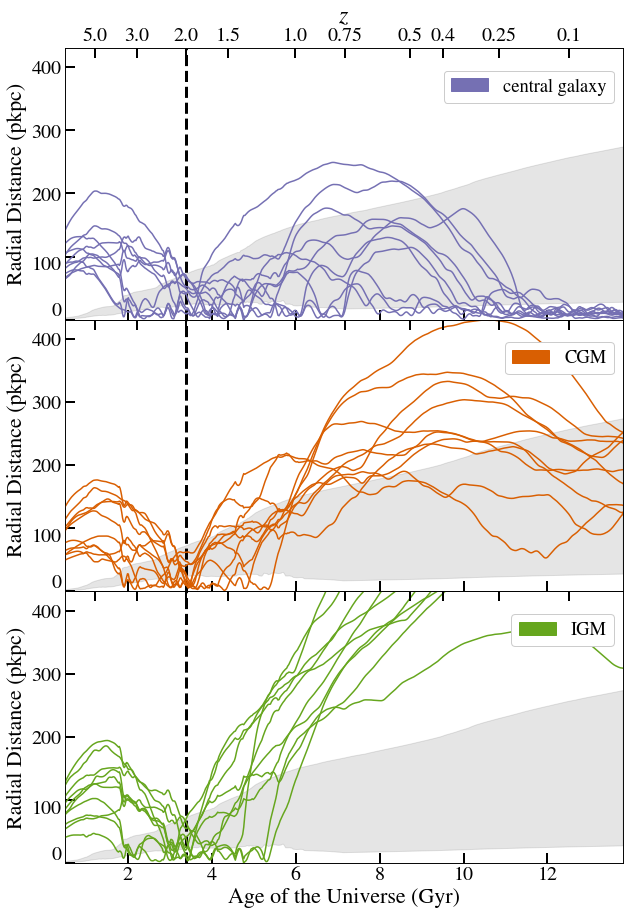

In [38]:
n_rows = len( used_classifications )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1 )

y_maxes = []
for i, classification in enumerate( used_classifications ):
    
    print( classification )
    
    ax = plt.subplot(gs[i,0])
    
#     if ax.is_first_row():
#         ax.annotate(
#             s = m_plot_label,
#             xy = (0,1.1),
#             xycoords = 'axes fraction',
#             va = 'bottom',
#             fontsize = 24,
#         )
    if classification == 'is_CGM_IP':
        ax.annotate(
            s = m_plot_label,
            xy = (0.05,0.95),
            xycoords = 'axes fraction',
            va = 'top',
            fontsize = 24,
        )
    
    gs.update(wspace=0.025, hspace=0.0001)
    
    w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
    
    class_y_max = w_plotter.plot_streamlines_vs_time(
        y_key = 'R',
        classification = classification,
        classification_ind = 0,
        start_ind = 0,
        end_ind = 595,
        sample_size = 10,
        y_data_kwargs = { 'smooth_data' : True },
        ax = ax,
        x_range = [0.5, 13.8 ],
        y_range = [0., 550, ],
        vert_line_ind = ind,
        horizontal_line_value = None,
        plot_CGM_region = True,
        CGM_region_alpha = 0.1,
        return_y_max = True,
#         classifications_to_color_on = p_constants.CLASSIFICATIONS_CGM_FATE,
#         ctco_ind = ind,
#         line_features = {
#             'is_class': {
#                 'key': classification,
#                 'value': True,
#                 'data_kwargs': {},
#                 'line_attrs': {
#                     'linewidth': 3,
#                     'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                     },
#             },
#             'is_gas': {
#                 'key': classification,
#                 'value': False,
#                 'data_kwargs': {},
#                 'line_attrs': {
#                     'linewidth': 1,
#                     'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                     'linestyle': '--',
#                     },
#                 }
#         },
    )
    y_maxes.append( class_y_max )
        
    # Make virtual artists to allow a legend to appear
    labels = []
    color_objects = []
    color_object = matplotlib.patches.Rectangle(                         
        (0, 0),                                                          
        1,                                                               
        1,                                                               
        fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        alpha = p_constants.CLASSIFICATION_ALPHA,                        
    )                                                                    
    color_objects.append( color_object )                                 
    labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
    
    # Plot the outer edge of the galaxy under galdefv2
#     ax.plot( w.get_data( 'time')[:r_gal.size], w.r_gal, color='k', linewidth=3.5 )

    # Legend
    l = ax.legend(
        color_objects,
        labels,
        prop={'size': 18.5},
        ncol=1,
        bbox_to_anchor=(1, 0.95),
        loc='upper right',
        fontsize=20,
        framealpha=1.,
    )
    l.set_zorder( 200. )
        
# Changes to axes
for i, classification in enumerate( used_classifications ):
    
    ax = plt.subplot(gs[i,0])
    ax.set_ylim( 0, 1.05*y_max )
    
    # Add redshift to the axis
    ax2 = plotting.add_redshift_to_axis(
        ax,
        hubble = w.ptracks.data_attrs['hubble'],
        omega_matter = w.ptracks.data_attrs['omega_matter'],
        tick_redshifts = np.array([ 0.1, 0.25, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, ])
    )
    
    # Change tick orientation
    ax.tick_params( direction='in' )
    ax2.tick_params( direction='in' )
    
    # Hide overlapping labels
    if not ax.is_first_row():
        ax2.xaxis.set_ticklabels([])
    if not ax.is_last_col():
        ax.xaxis.set_ticklabels([])
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[1].set_verticalalignment( 'top' )
    
    # X label
    if ax2.is_first_row():
        ax2.set_xlabel( r'$z$', fontsize=24 )
        
save_file = 'r_vs_time_eventual_{}.pdf'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

# Scratch

In [39]:
offset = 28

In [40]:
import galaxy_dive.analyze_data.halo_data as halo_data

In [41]:
w.r_vir.values[ind-offset]

86.74352347983331

In [42]:
h_data = halo_data.HaloData(
    data_dir = w.halo_data_dir,
    tag = None,
    mt_kwargs = {
        'tag': None,
        'index': 600,
    }
)

In [43]:
h_data.get_mt_data( 'Rvir', snums=[snum+offset], a_power=1. ) / w.hubble_param

array([49.82256966])

In [44]:
ejected_inds = np.arange(w.n_particles)[w.get_data( 'is_CGM_ejected', sl=(slice(None),ind) )]

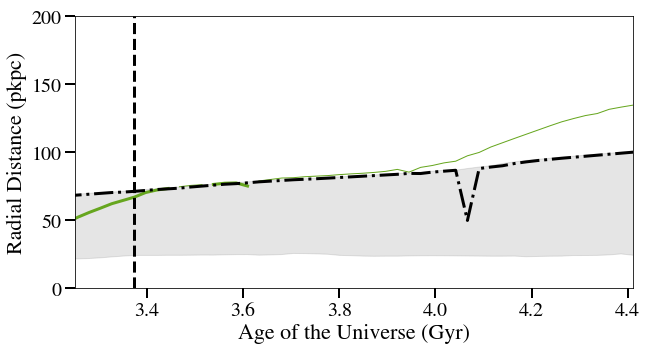

In [45]:
fig = plt.figure( figsize=(10,5), facecolor='white' )
ax = plt.gca()

w_plotter.plot_streamlines_vs_time(
    y_key = 'R',
#     classification = 'is_CGM_ejected',
    classification_ind = ind,
    start_ind = 0,
    end_ind = 595,
    sample_size = 10,
#     y_data_kwargs = { 'smooth_data' : True },
    ax = ax,
    x_range = [3.25, w.get_data( 'time' )[ind-offset-15] ],
#     x_range = [3.25, 5 ],
    y_range = [0, 200, ],
    horizontal_line_value = None,
    plot_CGM_region = True,
    CGM_region_alpha = 0.1,
    return_y_max = True,
#     classifications_to_color_on = p_constants.CLASSIFICATIONS_LOCATION,
#     ctco_ind = 0,
    sample_inds = ejected_inds[4:5],
    line_features = {
        'is_class': {
            'key': 'is_smoothed_in_CGM_or_interface_0.030',
            'value': True,
            'data_kwargs': {},
            'line_attrs': {
                'linewidth': 3,
                'color': p_constants.CLASSIFICATION_COLORS_B[classification],
                },
        },
        'is_gas': {
            'key': 'is_smoothed_in_CGM_or_interface_0.030',
            'value': False,
            'data_kwargs': {},
            'line_attrs': {
                'linewidth': 1,
                'color': p_constants.CLASSIFICATION_COLORS_B[classification],
                'linestyle': '-',
                },
            }
    },
)

ax.plot(
    w.get_data( 'time' )[::-1],
    h_data.get_mt_data( 'Rvir', snums=range(600), a_power=1. ) / w.hubble_param,
    linestyle = '-.',
    color = 'k',
    linewidth = 3,
)

fig

In [46]:
w.get_data( 'next_time_as_not_in_CGM_or_interface' )[ejected_inds[4:5],ind]

array([0.07060003])

In [47]:
w.get_data( 'is_in_main_gal' )[ejected_inds[4:5],ind-offset-1:ind]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False]])

In [48]:
w.get_data( 'is_in_IGM' )[ejected_inds[4:5],ind-offset-10:ind]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True, False,  True,  True,  True, False,
        False, False]])

In [49]:
w.get_data( 'is_CGM_ejected' )[ejected_inds[4:5],ind-offset-5:ind]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True, False,  True,
        False, False, False,  True,  True,  True]])

In [50]:
w.get_data( 'dt' )

array([0.0022192 , 0.00222301, 0.00221729, 0.00222015, 0.00221634,
       0.00222015, 0.00222206, 0.00222111, 0.00222206, 0.00222015,
       0.02222157, 0.02223682, 0.02226162, 0.02228069, 0.02230644,
       0.02232265, 0.02234554, 0.02236366, 0.0223875 , 0.02241135,
       0.02242279, 0.02245331, 0.02246666, 0.02249336, 0.02250957,
       0.02253628, 0.0225544 , 0.02257442, 0.02259445, 0.02261734,
       0.02263546, 0.0226593 , 0.0226841 , 0.0226984 , 0.02271938,
       0.02274323, 0.02276134, 0.02278614, 0.02280903, 0.02282619,
       0.02284145, 0.0228672 , 0.02289009, 0.02290726, 0.02293015,
       0.02294922, 0.02297878, 0.02299023, 0.02301121, 0.02303505,
       0.02305317, 0.02307796, 0.02309704, 0.02311707, 0.02313423,
       0.02316093, 0.02317715, 0.02320576, 0.0232172 , 0.02324104,
       0.02326107, 0.02328491, 0.02330017, 0.02332211, 0.02334785,
       0.02336121, 0.02339172, 0.02340508, 0.02342129, 0.02345181,
       0.02346611, 0.02348518, 0.02351093, 0.02352715, 0.02354

In [51]:
w.get_data( 'is_in_CGM_or_interface' )[ejected_inds[4:5],ind-offset-10:ind]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True, False, False, False,  True,
         True,  True]])

In [52]:
w.get_data( 'is_smoothed_in_CGM_or_interface_0.030' )[ejected_inds[4:5],ind-offset-1:ind]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True, False, False, False,  True,
         True,  True]])

In [53]:
w.get_data( 'next_time_as_not_smoothed_in_CGM_or_interface_0.030' )[ejected_inds[6:8],ind]

array([ 1.62367535, 10.19494486])

In [54]:
w.r_vir[snum+offset]

86.74352347983331

In [55]:
w.get_data( 'is_in_CGM_or_interface' )[ejected_inds[2],ind-29:ind]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [56]:
w.get_data( 'R' )[ejected_inds[2],ind-29:ind] / w.r_vir.values[ind-29:ind]

array([0.89383433, 0.66173369, 0.91523659, 0.91895975, 0.91472188,
       0.85107402, 0.92055071, 0.90644243, 0.90662855, 0.90864673,
       0.89779513, 0.86994857, 0.84057595, 0.81207092, 0.7850054 ,
       0.76997379, 0.76055672, 0.72043482, 0.68712314, 0.64368899,
       0.59617385, 0.54120565, 0.50406408, 0.46293752, 0.42318434,
       0.44706196, 0.46432855, 0.49828772, 0.53265356])

In [57]:
w.r_vir.values[ind-29:ind]

array([88.02674609, 86.74352348, 86.74352348, 86.06801414, 85.40044203,
       84.45762645, 84.45762645, 83.79089475, 83.29392143, 82.8449345 ,
       82.37600004, 81.89255351, 81.42558607, 80.96979064, 80.51485695,
       80.11649256, 79.75882986, 79.22045905, 78.73868459, 78.24311474,
       77.50617308, 76.91565906, 76.47451795, 75.8681297 , 75.11339274,
       74.42047901, 73.59109948, 73.10179688, 72.58999135])

In [58]:
w.get_data( '1.0_Rvir' )[ejected_inds[2],ind-28]

-2

In [59]:
w.galids.data.keys()

dict_keys(['1.0_Rvir', '2.0_Rvir', 'd_other_gal', 'd_other_gal_scaled', 'gal_id', 'mt_gal_id'])

## Try to recreate the galaxy-linking process

In [60]:
w.hubble_param

0.702

In [61]:
import galaxy_dive.galaxy_linker.linker as gal_linker

In [62]:
w.main_halo_id

0

In [63]:
positions = np.array([ w.get_data( 'P' )[:,ejected_inds[2],ind-offset].transpose() +  w.origin[:,ind-offset] ])

In [64]:
kwargs = {
    'particle_positions' : positions,
    'redshift': w.redshift.values[ind - offset],
    'snum': snum + offset,
    'hubble': w.hubble_param,
    'galaxy_cut': 1.0,
    'length_scale': 'Rvir',
    'halo_data_dir': w.halo_data_dir,
    'halo_file_tag': w.halo_data.data_reader.tag,
    'main_mt_halo_id': w.main_halo_id,
    'ids_to_return': [ '1.0_Rvir', ],
}

In [65]:
g_l = gal_linker.GalaxyLinker( **kwargs )

In [66]:
results = g_l.find_ids()
results

{'1.0_Rvir': array([-2])}

In [67]:
( results['1.0_Rvir'] != -2 ).sum()

0

#### Do we have the wrong data loaded?

In [68]:
g_l.valid_halo_inds

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   35,   36,   37,   38,   39,   40,   42,   43,   47,   48,
         49,   50,   51,   52,   54,   55,   56,   57,   60,   61,   65,
         68,   70,   86,   88,   89,   90,   91,   96,   99,  102,  103,
        107,  109,  112,  115,  126,  129,  132,  139,  140,  152,  159,
        160,  163,  240,  251,  257,  277,  287,  294,  297,  301,  356,
        369,  380,  384,  388,  412,  423,  429,  436,  496,  506,  550,
        555,  640,  667,  683,  686,  695,  699,  843,  901,  923,  994,
       1012, 1073, 1083, 1148, 1153, 1201, 1264, 2068, 2111, 2694, 3453,
       4167])

In [69]:
halo_r_virs = g_l.halo_data.get_data( 'Rvir', snum=snum+offset ) / ( 1. + w.redshift[snum+offset] ) /.702
halo_r_virs

unyt_array([ 49.82146218,  56.42450107,  49.92370972, ...,   4.49351058,
            127.47040123,   1.86736308], 'kpc')

In [70]:
snum+offset

200

In [71]:
w.redshift[snum+offset]

1.64705884

In [72]:
g_l.halo_data.get_mt_data( 'Rvir', snums=[snum+offset] ) / ( 1. + w.redshift[snum+offset] ) /.702

array([86.74352348])

In [73]:
g_l.halo_data.get_mt_data( 'ID', snums=[snum+offset] )

array([0])

In [74]:
w.origin[:,ind]

array([14292.67132949, 14158.92530661, 14950.77331151])

Nope, right data loaded.

### Am I using the code wrong?

Next step is running the actual pipeline but with a debug statement so I can see if I'm missing any args in the above test.

halo file

unsmoothed

In [75]:
1.39782e+11, 92.58

(139782000000.0, 92.58)

smooth

In [76]:
255628000000.0, 161.18987786930828

(255628000000.0, 161.18987786930828)

# More Scratch

In [77]:
accsat_inds = np.arange(w.n_particles)[w.get_data(
    'is_CGM_accreted_to_satellite', sl=(slice(None),ind)
)]

In [78]:
w_plotter.data_object.data_masker.clear_masks( True )

In [79]:
w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )

In [80]:
w_plotter.data_object.data_masker.mask_data( 'is_in_CGM_not_sat', data_value=True, optional_mask=True, mask_name='CGM' )

In [81]:
fig = plt.figure( figsize=(10,5), facecolor='white' )
ax = plt.gca()


w_plotter.plot_streamlines_vs_time(
    y_key = 'R',
    classification = 'is_CGM_fate_unclassified',
    classification_ind = ind,
    start_ind = 0,
    end_ind = 595,
    sample_size = 3,
#     y_data_kwargs = { 'smooth_data' : True },
    ax = ax,
#     x_range = [3.25, w.get_data( 'time' )[ind-offset-2] ],
    x_range = [ 3.3, 4.5 ],
    y_range = [0., 100, ],
    horizontal_line_value = None,
    plot_CGM_region = True,
    CGM_region_alpha = 0.1,
    return_y_max = True,
    optional_masks = [ 'CGM' ],
#     classifications_to_color_on = p_constants.CLASSIFICATIONS_LOCATION,
#     ctco_ind = 0,
#     sample_inds = ejected_inds[10:15],
#     line_features = {
#         'is_class': {
#             'key': 'is_in_IGM',
#             'value': True,
#             'data_kwargs': {},
#             'line_attrs': {
#                 'linewidth': 3,
#                 'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                 },
#         },
#         'is_gas': {
#             'key': 'is_in_IGM',
#             'value': False,
#             'data_kwargs': {},
#             'line_attrs': {
#                 'linewidth': 1,
#                 'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                 'linestyle': '--',
#                 },
#             }
#     },
)

ax.plot(
    w.get_data( 'time' )[::-1],
    h_data.get_mt_data( 'Rvir', snums=range(600), a_power=1. ) / w.hubble_param,
    linestyle = '-.',
    color = 'k',
    linewidth = 3,
)

fig

ValueError: a must be non-empty

In [ ]:
# Start from a fresh slate
w_plotter.data_object.data_masker.clear_masks( True )
# Choose only gas
w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
w_plotter.data_object.data_masker.mask_data( 'is_in_CGM_not_sat', data_value=True )

In [ ]:
unclassified = w_plotter.get_selected_data( 'is_CGM_fate_unclassified', sl=(slice(None), ind) )

In [ ]:
unclassified_inds = np.arange(w.n_particles)[unclassified]